# Introduction

You are the new mayor of a mid-sized city in the southern United States. You campaigned on a promise to reduce crime and now it's time to make good. 

You have two promising programs aimed at those at highest risk of re-arrest. 

For the final project we are going to decide between these two programs.  

```
1) A custom notification program
Under this program, police officers visit the homes of high-risk individuals and notify them of their status. They additionally warn these individuals that the police is keeping a closer eye on them. The custom notification program is relatively cheap to run, so it can serve 1,000 individuals, but it will likely lead to more people being arrested.
```

```
2) A summer jobs program
Under this program, social workers visit the homes of high-risk individuals and offer them a slot in a summer jobs program which has been shown to be effective in increasing employment and reducing criminal justice involvement. The summer jobs program is expensive to run, so it can serve 500 individuals, but many of those served will likely not have been re-arrested even without the program. 
```

In [137]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# YOU ARE FREE TO USE WHATEVER ALGORITHM YOU WANT BUT I HAVE IMPORTED SOME FOR YOU BELOW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score as auc
from sklearn.ensemble import RandomForestClassifier as RF_clf
from sklearn.linear_model import LogisticRegression as LR_clf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Part 1 

## Load data
We will work with the following dataset:
 - **Xy**: Has the following columns 
   - `ArresteeID`: Unique ID for an arrestee
   - `outcome__rearrested_in_2019` : The outcome to predict
   - `charges__NIBRS_Group_X__YYYY` : This is a count of the number of charges of type X in the year YYYY. 
     - X is either A, B or C
     - YYYY is either 2016, 2017, or 2018
   - `arrests__race__XXXX` : Where XXXX is either Black, Hispanic, Other, or White
 - **arrests** : 
   - `IncidentNum`: Unique ID for an incident
   - `ArrestYr`: Year of arrest
   - `ArrestNumber`: Unique ID for an arrest
   - `ArWeapon` : Any weapons identified by the arresting officer
   - `arr_age`: Current age of arrestee
   - `arr_gender`: Gender of arrestee at incident
   - `ArresteeID`: Unique ID for an arrestee
 - **charges** : 
   - `ArrestNumber`: Unique ID for an arrest
   - `ArChgNumID`: Unique ID for an arrest charge
   - `Severity`: Misdemeanor or Felony
   - `NIBRS_Group`: Is charge of type A (most severe), B (less severe), or C (traffic incident)
   - `NIBRS_Crime_Category`: The category of the charge
 - **incidents** : 
   - `IncidentNum`: Unique ID for an incident
   - `incident_type`: Free text field describing the incident
   - `vic_type`: Whether the victim was a person, business, law enforcement, or the government 
   - `mo`: Free text field briefly describing the incident
   - `weapon_used`: Free text field listing the type of weapon if any
   - `gang_related`: Indication if the incident was gang-related
   
 
Both datasets have the following columns:
  - **`outcome__rearrested_in_2019`**: The actual outcome
  - **`race__Black`** : A binary-valued column with 1=Black 0=Not Black
  - **`race__White`** : A binary-valued column with 1=White 0=Not White
  - **`race__Hispanic`** : A binary-valued column with 1=Hispanic or Latino 0=Not Hispanic or Latino
  - **`gender__M`** : A binary-valued column with 1=Male gender and 0=Non-Male
  - **`network__any_1st_deg_nabe__all`** : A binary-valued column that tells us whether the person has ever been arrested with someone else
  - **`prediction` : The models predicted probability of the outcome

## Prediction Setup
We will be predicting whether someone arrested in 2018 will be re-arrested in 2019.



In [138]:
Xy = pd.read_csv('./Xy_final_project.csv')
arrests = pd.read_csv('./arrests_final_project.csv')
charges = pd.read_csv('./charges_final_project.csv')
incidents = pd.read_csv('./incidents_final_project.csv')

Xy
arrests.head()
charges.head()
incidents.head()

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
3,2856607,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0
4,2921408,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12238,102720805,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
12239,102724697,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0
12240,102730586,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
12241,102758342,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0


,IncidentNum,ArrestYr,ArrestNumber,ArWeapon,arr_age,arr_gender,ArresteeID
0,104552-2020,2020,20-018820,Unarmed,51.0,Male,102468259
1,104552-2020,2020,20-018820,Unarmed,51.0,Male,8607720
2,104552-2020,2020,20-018820,Unarmed,51.0,Male,102253069
3,104552-2020,2020,20-018820,Unarmed,51.0,Male,102366171
4,104552-2020,2020,20-018820,Unarmed,51.0,Male,102315487


,ArrestNumber,ArChgNumID,Severity,NIBRS_Group,NIBRS_Crime_Category
0,14-036903,14-036903-01,F,A,DRUG/ NARCOTIC VIOLATIONS
1,16-012390,16-012390-01,M,B,DRIVING UNDER THE INFLUENCE
2,15-048343,15-048343-01,M,B,PUBLIC INTOXICATION
3,16-015720,16-015720-03,M,C,TRAFFIC VIOLATION - NON HAZARDOUS
4,15-040648,15-040648-01,M,B,DRIVING UNDER THE INFLUENCE


,IncidentNum,incident_type,vic_type,mo,weapon_used,gang_related
0,207055-2018,ASSAULT -PUB SERV (PEACE OFFICER/JUDGE),Law Enforcement Offi,A/P BIT OFFICER ON THE LEFT HAND CAUSING INJURY,Personal Weapons (Hands-Feet ETC),UNK
1,243817-2018,TRAF VIO -OPERATE MOTOR VEH W/O FIN RESP,Government,A/P WAS UNABLE TO PROVIDE PROOF OF INSURANCE,NaN,NaN
2,245226-2018,OTHER OFFENSE - MISDEMEANOR,Government,AP WAS IN POSSESSION OF DRUG PARAPHERNALIA,NaN,NaN
3,133767-2019,POSS MARIJUANA <2OZ,Government,A/P WAS IN POSSESSION OF MARIJUANA.,NaN,NaN
4,273676-2018,POSS CONT SUB PEN GRP 1 <1G,Government,AP WAS IN POSSESSION OF COCAINE,NaN,NaN


## Learning about our outcome (2 total points)
1) Using `Xy`, what is the share of 2018 arrestees were arrested in 2019. Would you say this is a high or low base rate? (1 point)

2) Repeat 1) but now by the three race categories. Which race group has the highest base rate? (1 point)



In [139]:
#code here
Xy2018= Xy[(Xy['charges__NIBRS_Group_A__2018']>0) | (Xy['charges__NIBRS_Group_B__2018']>0) | (Xy['charges__NIBRS_Group_C__2018']>0)]
crim_2018 = Xy2018[Xy2018['outcome__rearrested_in_2019'] == 1]['outcome__rearrested_in_2019'].shape[0]
crim_rearrested= Xy2018.shape[0]

base_rate_total=crim_rearrested/crim_2018

crim_2018
crim_rearrested
base_rate_total

# Only 13.84% of arrestees from 2018 were rearrested in 2019 (879/12167). Overall, this is a fairly low base rate

Xy_2018_Black = Xy2018[Xy2018['arrests__race__Black']>0]
black_2018= Xy_2018_Black[Xy_2018_Black['outcome__rearrested_in_2019'] == 1]['outcome__rearrested_in_2019'].shape[0]
black_rearrested = Xy_2018_Black.shape[0]

base_rate_black= black_rearrested/black_2018

black_2018
black_rearrested
base_rate_black

# 11.92% (465/5543) of black arrestees from 2018 were rearrested in 2019

Xy_2018_Hispanic = Xy2018[Xy2018['arrests__race__Hispanic']>0]
hispanic_2018= Xy_2018_Hispanic[Xy_2018_Hispanic['outcome__rearrested_in_2019'] == 1]['outcome__rearrested_in_2019'].shape[0]
hispanic_rearrested = Xy_2018_Hispanic.shape[0]

base_rate_hispanic= hispanic_rearrested/hispanic_2018

hispanic_2018
hispanic_rearrested
base_rate_hispanic

# 16.84% (218/3671) of hispanic arrestees from 2018 were rearrested in 2019

Xy_2018_White = Xy2018[Xy2018['arrests__race__White']>0]
white_2018= Xy_2018_White[Xy_2018_White['outcome__rearrested_in_2019'] == 1]['outcome__rearrested_in_2019'].shape[0]
white_rearrested = Xy_2018_White.shape[0]

base_rate_white= white_rearrested/white_2018

white_2018
white_rearrested
base_rate_white

#15.10% (182/2748) of white arrestees from 2018 were rearrested in 2019
#Of these three race groups, hispanics have the highest base rate according to this data

879

12167

13.841865756541525

465

5543

11.920430107526881

218

3671

16.839449541284402

182

2748

15.098901098901099

## Feature Generation (5.5 total points, 2 extra credit points)
1) Create a feature (or features) using the `incidents` data frame and merge these features into Xy. (1.5 points)
 
  

2) Create one or more features of your choice using any of the data frames you'd like (2 points, 2 additional extra credit points for creativity of your feature). Merge these features in with Xy as well.
 
 

3) Use sns.regplot to create two separate plots that show the relationship between the features you created and the outcome. (If you created more than two features, just pick two and plot) Based on these plots, which feature is more predictive of the outcome? (2 point)

 
 
 

,IncidentNum,POSS MARIJUANA <2OZ
0,207055-2018,0
1,243817-2018,0
2,245226-2018,0
3,133767-2019,1
4,273676-2018,0
...,...,...
17079,176622-2018,0
17080,057684-2018,0
17081,197422-2018,0
17082,148427-2018,0


,ArresteeID,Male_under_30,Male_30+,Female_under_30,Female_30+
0,102468259,0,1,0,0
1,8607720,0,1,0,0
2,102253069,0,1,0,0
3,102366171,0,1,0,0
4,102315487,0,1,0,0
...,...,...,...,...,...
82743,12014644,1,0,0,0
82744,101558117,0,1,0,0
82745,101145441,0,0,0,1
82746,100119297,0,0,1,0


,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White,POSS MARIJUANA <2OZ,Male_under_30,Male_30+,Female_under_30,Female_30+
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0.0,0,0,0,1
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,0.0,0,1,0,0
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0.0,0,1,0,0
3,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0.0,0,1,0,0
4,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83560,102765292,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0.0,0,1,0,0
83561,102765292,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0.0,0,1,0,0
83562,102765292,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0.0,0,1,0,0
83563,102765292,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0.0,0,1,0,0


<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='POSS MARIJUANA <2OZ', ylabel='outcome__rearrested_in_2019'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Male_30+', ylabel='outcome__rearrested_in_2019'>

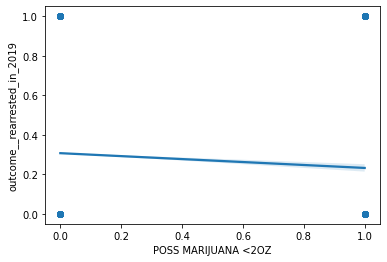

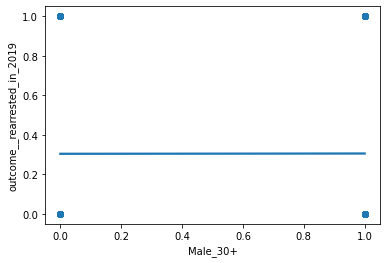

In [140]:
#code here
#Feature from incidents df: possession of marijuana charge
incidents_marijuana= pd.concat([incidents['IncidentNum'], pd.get_dummies(incidents.incident_type)['POSS MARIJUANA <2OZ']], axis=1)
incidents_marijuana

arrests_marijuana= arrests.merge(incidents_marijuana, on='IncidentNum', how='outer').fillna(0)
arrests_marijuana= arrests_marijuana[['ArresteeID','POSS MARIJUANA <2OZ']]

Xy= Xy.merge(arrests_marijuana, on='ArresteeID', how='left')


#Features from other dataframes: Comparing age (30+ vs under 30) for both men and women
arrests['Male_under_30'] = np.where((arrests['arr_age'] < 30) & (arrests['arr_gender']== 'Male'), 1, 0)
arrests['Male_30+'] = np.where((arrests['arr_age'] >= 30) & (arrests['arr_gender']== 'Male'), 1, 0)
arrests['Female_under_30'] = np.where((arrests['arr_age'] < 30) & (arrests['arr_gender']== 'Female'), 1, 0)
arrests['Female_30+'] = np.where((arrests['arr_age']>=30) & (arrests['arr_gender']== 'Female'), 1, 0)

arrests_gender_age= arrests[['ArresteeID','Male_under_30','Male_30+','Female_under_30','Female_30+']]

arrests_gender_age

Xy=Xy.merge(arrests_gender_age, on='ArresteeID', how='left')
Xy

plt.figure()
marijuana_plot= sns.regplot(x='POSS MARIJUANA <2OZ', y='outcome__rearrested_in_2019', data=Xy)
marijuana_plot

plt.figure()
oldman_plot= sns.regplot(x='Male_30+', y='outcome__rearrested_in_2019', data=Xy)
oldman_plot

#according to these two plots, being charged with marijuana possession is more predictive of if an arrestee will be rearrested
#in 2019. This is due to the fact that the graph shows a negative correlation, indicating it has some effect. The 
#graph depicting men over the age of 30 has little to no slope, possibly indicating that this factor has no effect
#on whether someone will be rearrested.

## Build models (5 points)
We are going to build two models. 

1) 
The first one will NOT include any of the features that you built. 

These are the set of features to include in the first model.
```
feature_names = ['charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White']
```


2) The second model WILL include the features you built (and include the features from 1))


Using the algorithm of your choice (e.g. decision trees, logistic regression, random forest, etc), train a model to predict `outcome__rearrested_in_2019` for both 1) and 2). 

Note:
 - For full credit you **MUST** perform hyperparameter tuning. See Lab 9 for guidance here.  
 - Make sure you have created a holdout/test set before training the models.
 - Make sure to show the selected hyperparameters after tuning for both models.

Generate predictions for your test/holdout set. 

The predictions from 1) should be in a column called `predictions_standard`

The predictions from 2) should be in a column called `predictions_augmented`


In [162]:
#code here
feature_names = ['charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White']

feature_names_expanded = ['charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White','POSS MARIJUANA <2OZ','Male_under_30','Male_30+',
       'Female_under_30','Female_30+']

outcome= 'outcome__rearrested_in_2019'

X_train, X_test, y_train, y_test = train_test_split(Xy, Xy[outcome], test_size=.3)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

rf_model = RF_clf()

param_grid = {'max_depth' : [1,5,10],
              'max_features' : [1, 2, 3],
              'n_estimators' : [200]}

gs_cv1 = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='average_precision')

gs_cv1.fit(X_train[feature_names], y_train)
print(gs_cv1.best_params_)

gs_cv2 = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='average_precision')

gs_cv2.fit(X_train[feature_names_expanded], y_train)
print(gs_cv2.best_params_)

test_results = pd.DataFrame({'outcome__rearrested_in_2019' : y_test,
                             'race_Black' : X_test['arrests__race__Black'],
                             'race_Hispanic' : X_test['arrests__race__Hispanic'],
                             'race_White' : X_test['arrests__race__White'],
                             'predictions_standard' : gs_cv1.predict_proba(X_test[feature_names])[:,1],
                             'predictions_augmented' : gs_cv2.predict_proba(X_test[feature_names_expanded])[:,1]})
test_results.head()

C:\Users\Thomas\anaconda3\envs\inst_414_f2021\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10], 'max_features': [1, 2, 3],
                         'n_estimators': [200]},
             scoring='average_precision')

{'max_depth': 10, 'max_features': 3, 'n_estimators': 200}


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10], 'max_features': [1, 2, 3],
                         'n_estimators': [200]},
             scoring='average_precision')

{'max_depth': 10, 'max_features': 3, 'n_estimators': 200}


,outcome__rearrested_in_2019,race_Black,race_Hispanic,race_White,predictions_standard,predictions_augmented
53934,0,1,0,0,0.028929,0.071271
26358,0,0,1,0,0.104632,0.069408
68029,0,1,0,0,0.348130,0.331645
32695,0,0,0,1,0.001422,0.012330
58780,0,0,0,1,0.364681,0.373857


##  Model performance (4.5 total points)
We are now going to compute precision, recall, and AUC for **both** sets of predictions.

1) Compute precision and recall using the appropriate threshold for the summer jobs program. (0.5 points)



2) Compute precision and recall using the appropriate threshold for the custom notification program. (0.5 points)



3) Compute AUC (0.5 points)



4) Based on your results here, are your features improving performance? And where in the distribution is performance being improved? Justify your answer using the results from 1), 2) , and 3) and the meaning of the performance metrics (3 points)

In [163]:
#code here

#setting up crosstabs
test_results_standard = test_results
test_results_standard.sort_values('predictions_standard', ascending=False, inplace=True)
test_results_standard['yhat_summer']=0
test_results_standard['yhat_notification']=0
test_results_standard['yhat_summer'][0:499]=1
test_results_standard['yhat_notification'][0:999]=1
test_results_standard

test_results_augmented = test_results
test_results_augmented.sort_values('predictions_augmented', ascending=False, inplace=True)
test_results_augmented['yhat_summer']=0
test_results_augmented['yhat_notification']=0
test_results_augmented['yhat_summer'][0:499]=1
test_results_augmented['yhat_notification'][0:999]=1
test_results_augmented

cm_standard_summer= pd.crosstab(test_results_standard.yhat_summer, test_results_standard.outcome__rearrested_in_2019)
cm_standard_summer

cm_standard_notification= pd.crosstab(test_results_standard.yhat_notification, test_results_standard.outcome__rearrested_in_2019)
cm_standard_notification

cm_augmented_summer= pd.crosstab(test_results_augmented.yhat_summer, test_results_augmented.outcome__rearrested_in_2019)
cm_augmented_summer

cm_augmented_notification= pd.crosstab(test_results_augmented.yhat_notification, test_results_augmented.outcome__rearrested_in_2019)
cm_augmented_notification

#Summer jobs program

#standard
#Precision:
print('Standard summer jobs precision: ',(cm_standard_summer.iloc[1,1])/(cm_standard_summer.iloc[1,:].sum()))
#Recall:
print('Standard summer jobs recall: ',(cm_standard_summer.iloc[1,1])/(cm_standard_summer.iloc[:,1].sum()))

#augmented
#Precision:
print('Augmented summer jobs precision: ',(cm_augmented_summer.iloc[1,1])/(cm_augmented_summer.iloc[1,:].sum()))
#Recall:
print('Augmented summer jobs recall: ',(cm_augmented_summer.iloc[1,1])/(cm_augmented_summer.iloc[:,1].sum()))

#Custom notification program:
#standard
#Precision:
print('Standard notification program precision: ',(cm_standard_notification.iloc[1,1])/(cm_standard_notification.iloc[1,:].sum()))
#Recall:
print('Standard notification program recall: ',(cm_standard_notification.iloc[1,1])/(cm_standard_notification.iloc[:,1].sum()))

#augmented
#Precision:
print('Augmented notification program precision: ',(cm_augmented_notification.iloc[1,1])/(cm_augmented_notification.iloc[1,:].sum()))
#Recall:
print('Augmented notification program recall: ',(cm_augmented_notification.iloc[1,1])/(cm_augmented_notification.iloc[:,1].sum()))


#AUC

#Standard
print('AUC of the standard feature set: ', auc(y_test, test_results['predictions_standard'], multi_class= 'ovo'))

#Augmented
print('AUC of the augmented feature set: ', auc(y_test, test_results['predictions_augmented'], multi_class= 'ovo'))

#According to the two models, the new features that I created (checking if the arrestee was arrested for possession of
#marijuana, as well as combinations of age and sex),did not have some effect on the model's performance. The reasoning
#behind this is due to the fact that the precision (aka positive predictive value, or the percentage of values the model 
#predicted as positives were true positives) and recall (aka true positive rate, or what percentage of the actual positive
#values did the model predict as positive aka true positives) were the same for each model. The areas under the curve
#for each model do differ slightly, meaning the model incorporating the new features was slightly less strong at 
#distinguishing between positive and negative values. (The AUC  describes the interaction between the graph of a model's 
#true positive rate vs its false positive rate). This leads me to the conclusion that the features that I selected
#(arrests for marijuana possession and specific age-sex demographics) are not predictors for a possible rearrest, and
#in future models other sources of data should be seeked out.


C:\Users\Thomas\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Thomas\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,outcome__rearrested_in_2019,race_Black,race_Hispanic,race_White,predictions_standard,predictions_augmented,yhat_summer,yhat_notification
46106,1,0,1,0,0.986976,0.964352,1,1
47770,1,0,1,0,0.986976,0.964352,1,1
46116,1,0,1,0,0.986976,0.964352,1,1
46114,1,0,1,0,0.986976,0.964352,1,1
16653,1,0,1,0,0.986976,0.964352,1,1
...,...,...,...,...,...,...,...,...
41069,0,0,0,1,0.000000,0.000304,0,0
49904,0,0,0,1,0.000000,0.000304,0,0
49799,0,0,0,1,0.000000,0.000304,0,0
49911,0,0,0,1,0.000000,0.000304,0,0


C:\Users\Thomas\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Thomas\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,outcome__rearrested_in_2019,race_Black,race_Hispanic,race_White,predictions_standard,predictions_augmented,yhat_summer,yhat_notification
46106,1,0,1,0,0.986976,0.964352,1,1
55197,1,0,1,0,0.986976,0.964352,1,1
55231,1,0,1,0,0.986976,0.964352,1,1
46014,1,0,1,0,0.986976,0.964352,1,1
51227,1,0,1,0,0.986976,0.964352,1,1
...,...,...,...,...,...,...,...,...
49581,0,0,0,1,0.000000,0.000304,0,0
9827,0,0,0,1,0.000000,0.000304,0,0
9261,0,0,0,1,0.000000,0.000304,0,0
40946,0,0,0,1,0.000000,0.000304,0,0


outcome__rearrested_in_2019,0,1
yhat_summer,,
0,17408,7163
1,0,499


outcome__rearrested_in_2019,0,1
yhat_notification,,
0,17408,6663
1,0,999


outcome__rearrested_in_2019,0,1
yhat_summer,,
0,17408,7163
1,0,499


outcome__rearrested_in_2019,0,1
yhat_notification,,
0,17408,6663
1,0,999


Standard summer jobs precision:  1.0
Standard summer jobs recall:  0.06512659879926912
Augmented summer jobs precision:  1.0
Augmented summer jobs recall:  0.06512659879926912
Standard notification program precision:  1.0
Standard notification program recall:  0.13038371182458888
Augmented notification program precision:  1.0
Augmented notification program recall:  0.13038371182458888
AUC of the standard feature set:  0.4960324664933514
AUC of the augmented feature set:  0.49735092033522


# Part 2
Now we are going to decide whether to select the custom notification or summer jobs program.

We are only going to use `prediction_standard` or `prediction_augmented` in this section, so also first decide which one you would prefer to use.

The same algorithm will be used for both programs, all that will be different is which threshold will be used (500 for summer jobs, 1000 for custom notifications).

## Total Impact (3 total points, 1 EC point)
We first want to know what the potential for total impact is. 

- So compute: (1 point)
  - the number of arrests in 2019.
  - the number of arrests that would be accounted for by the top 500 in predicted risk. 
  - the number of arrests that would be accounted for by the top 1,000 in predicted risk. 


- Custom notifications **reduce the chance of re-arrest by 50%** (meaning that the number of arrests accounted for by the top 1,000 would be cut in half). Compute what percentage of 2019 arrests would be eliminated if the custom notification program targeted the top 1,000 and reduced re-arrest by 50%. (2 points) *(Hint: First use the fact that the number re-arrests in the top 1,000 would be cut in half, then divide that number by the total number of 2019 arrests.)*



- Summer jobs reduce the chance of re-arrest by 100% (meaning the number arrests accounted for by the top 500 would go down to zero. Compute what percentage of 2019 arrests would be eliminated if the summer jobs program targeted the top 500 and reduced re-arrest by 100%. (1 points)


**Extra Credit**: (2 points)
Jurisdictions typically care about reducing felonies much more than reducing misdemeanors. 

Compute the number of felony arrests that would be prevented by summer jobs
Compute the number of felony arrests that would be prevented by custom notifications





In [164]:
# code here
arrests_2019= test_results_standard[test_results_standard['outcome__rearrested_in_2019'] == 1]['outcome__rearrested_in_2019'].shape[0]
arrests_2019

top_500= test_results_standard[test_results_standard['yhat_summer'] ==1 ]['outcome__rearrested_in_2019'].shape[0]
top_500


top_1000 = test_results_standard[test_results_standard['yhat_notification'] ==1 ]['outcome__rearrested_in_2019'].shape[0]
top_1000


notification_reduction= (top_1000/2)/arrests_2019
notification_reduction

summer_reduction= (top_500)/arrests_2019
summer_reduction

#Extra Credit
num_felonies= charges[charges['Severity'] == 'F']['Severity'].shape[0]
percent_felonies=num_felonies/charges['Severity'].shape[0]
percent_felonies
theoretical_felonies=percent_felonies*arrests_2019
theoretical_felonies
summer_felonies_reduced=summer_reduction*theoretical_felonies
notification_felonies_reduced=notification_reduction*theoretical_felonies

summer_felonies_reduced
notification_felonies_reduced
#Both programs would reduce 116 felonies

7662

499

999

0.06519185591229444

0.06512659879926912

0.23349150202743507

1789.0118885342076

116.5122595116901

116.62900526270383

## Calculating Cost (3 total points)
- Let's assume that it costs the city \$1,000 for each person enrolled in the custom notification program. First calculate the total cost of the program. Then divide this number by the total number of re-arrests prevented from part 3.1. This figure is the **cost per re-arrest prevented** (2 points)


- Let's assume that it costs the city \$5,000 for each person enrolled in the summer jobs program program. First calculate the total cost of the program. Then divide this number by the total number re-arrests prevented from part 3.1.  (1 point)





In [165]:
#code here
total_cost_notification= 1000*1000
cprp_notification=total_cost_notification/(top_1000/2)
cprp_notification

total_cost_summer= 5000*500
cprp_summer= total_cost_summer/top_500
cprp_summer

2002.002002002002

5010.0200400801605

## Fairness (3 total points)
As a mayoral candidate, you campaigned on injecting more fairness into the criminal justice process, so you would like this program to be as fair as possible. 

You care about two things:
1) If a program is going to potentially limit people's civil liberties, you want the False Positive Rates across groups to be as close to each other as possible. 


2) If a program involves the offer of a service (and is not punitive), you want the group with the highest base rate to also have the highest precision. (The mayor's reasoning here is that the groups most likely to be re-arrested are also among the most disadvantaged socio-economically, therefore, it is the mayor's belief that scarce resources should be allocated to the True Positives of those groups first.)

### FPR balance (See Lab 9 for creating confusion matrices by subgroup)
- Compute the false positive rate for for Black individuals in the top 1000 (0.5 points)


- Compute the false positive rate for for Hispanic individuals in the top 1000 (0.5 points)


- Compute the false positive rate for for White individuals in the top 1000 (0.5 points)



### Precision 

- Compute the precision for White individuals in the top 500 (0.5 points)


- Compute the precision for Black individuals in the top 500 (0.5 points)


- Compute the precision for White individuals in the top 500 (0.5 points)



In [185]:
#code here
#confusion matrices-top 1000
cm_top_1000_Black= pd.crosstab(test_results_standard[test_results_standard.race_Black==1].yhat_notification,
                               test_results_standard[test_results_standard.race_Black==1].outcome__rearrested_in_2019)
cm_top_1000_Hispanic= pd.crosstab(test_results_standard[test_results_standard.race_Hispanic==1].yhat_notification,
                               test_results_standard[test_results_standard.race_Hispanic==1].outcome__rearrested_in_2019)
cm_top_1000_White= pd.crosstab(test_results_standard[test_results_standard.race_White==1].yhat_notification,
                               test_results_standard[test_results_standard.race_White==1].outcome__rearrested_in_2019)

cm_top_1000_Black
cm_top_1000_Hispanic
cm_top_1000_White

# FPR Balance
# Black individuls
print('The False Positive rate for Black individuals in the top 1000 is ',(cm_top_1000_Black.iloc[1,0])/cm_top_1000_Black.iloc[1,:].sum())

#Hispanic Individuals
print('The False Positive rate for Hispanic individuals in the top 1000 is ',(cm_top_1000_Hispanic.iloc[1,0])/cm_top_1000_Hispanic.iloc[1,:].sum())


#White Individuals
print('The False Positive rate for White individuals in the top 1000 is ',(cm_top_1000_White.iloc[1,0])/cm_top_1000_White.iloc[1,:].sum())


#confusion matrices- top 500
cm_top_500_Black= pd.crosstab(test_results_standard[test_results_standard.race_Black==1].yhat_summer,
                               test_results_standard[test_results_standard.race_Black==1].outcome__rearrested_in_2019)
cm_top_500_Hispanic= pd.crosstab(test_results_standard[test_results_standard.race_Hispanic==1].yhat_summer,
                               test_results_standard[test_results_standard.race_Hispanic==1].outcome__rearrested_in_2019)
cm_top_500_White= pd.crosstab(test_results_standard[test_results_standard.race_White==1].yhat_summer,
                               test_results_standard[test_results_standard.race_White==1].outcome__rearrested_in_2019)

test_results_standard[(test_results_standard['race_White']==1) & test_results_standard['yhat_summer']==1]
#no arrestees that were white were put in the top 500, therefore cannot calculate presicion as the summer program would not
#affect any white people.


cm_top_500_Black
cm_top_500_Hispanic
cm_top_500_White

# Precision

# Black individuals
print('The precision (ppv) for Black individuals in the top 500 is ',(cm_top_500_Black.iloc[1,1])/cm_top_500_Black.iloc[1,:].sum())

# Hispanic Individuals
print('The precision (ppv) for Hispanic individuals in the top 500 is ',(cm_top_500_Hispanic.iloc[1,1])/cm_top_500_Hispanic.iloc[1,:].sum())

# White Individuals
print('The precision (ppv) for White individuals in the top 500 is not applicable, as no white individuals were put in the top 500 of this model.')

outcome__rearrested_in_2019,0,1
yhat_notification,,
0,10736,3073
1,0,351


outcome__rearrested_in_2019,0,1
yhat_notification,,
0,2786,1303
1,0,443


outcome__rearrested_in_2019,0,1
yhat_notification,,
0,3798,2213
1,0,205


The False Positive rate for Black individuals in the top 1000 is  0.0
The False Positive rate for Hispanic individuals in the top 1000 is  0.0
The False Positive rate for White individuals in the top 1000 is  0.0


,outcome__rearrested_in_2019,race_Black,race_Hispanic,race_White,predictions_standard,predictions_augmented,yhat_summer,yhat_notification


outcome__rearrested_in_2019,0,1
yhat_summer,,
0,10736,3368
1,0,56


outcome__rearrested_in_2019,0,1
yhat_summer,,
0,2786,1303
1,0,443


outcome__rearrested_in_2019,0,1
yhat_summer,,
0,3798,2418


The precision (ppv) for Black individuals in the top 500 is  1.0
The precision (ppv) for Hispanic individuals in the top 500 is  1.0
The precision (ppv) for White individuals in the top 500 is not applicable, as no white individuals were put in the top 500 of this model.


# Part 3: Putting It All Together (4 total points; 1 EC point)

Now you have to make a choice. 
Decide whether you will use the algorithm to target the custom notification program or the summer jobs program.

You should mention the following dimensions when you describe your reason for choosing one program over the other:
- Predictive performance
- Potential for impact
- Cost Effectiveness
- Fairness considerations

You must cite numbers from your analysis above to receive full credit.

**Extra credit** (2 points)
If you did the extra credit in 3.1, would the impact on felony arrests change your answer above, why or why not?

In [ ]:
# After careful consideration, I believe that the algorithm should be used to target the custom notification program.
# There are many reasons that led me to choose this program over the summer jobs program. Firstly, the increase in the
# number of people included in the program led to the algorithm having a better predictive performance when targeting
# the custom notification program. While both programs had the same level of precision, the notification program had
# nearly double the true positive rate of the summer jobs program, at 0.13 vs 0.7. Secondly, the program is much more
# cost-effective, with a cost per rearrest prevented of $2002 vs the summer jobs program's $5010. Finally, there are
# no factors such as Fairness considerations or a larger potential for impact that could make the summer jobs program
# more likable, as both programs had an equal percentage reduction in rearrests at 0.065%, and the prediction program
# had equal false positive rates for the major racial backgrounds (indicating that there was no inherant bias in the 
# way the program worked). Due to these factors, It is my opinion that the custom notification program is the clear winner
# when using this particular model.

#Extra credit
# The impact on felony arrests would not change my above answer, but only because there would be an equal reduction in 
# the number of felonies for each model, meaning there would be no reason to switch. Had the summer jobs program had a
# significant increase in the number of felonies reduced, then I would likely have chosen it despite all of the other
# factors that led me to initially choose the custom notification program.